# Imports

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Test.csv to Test.csv
Saving Train.csv to Train.csv
Saving Valid.csv to Valid.csv


In [2]:
!pip install pandas-profiling==3.1.0
!pip install transformers

     |████████████████████████████████| 261 kB 5.1 MB/s 
     |████████████████████████████████| 102 kB 12.8 MB/s 
     |████████████████████████████████| 3.1 MB 40.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 675 kB 54.9 MB/s 
     |████████████████████████████████| 10.9 MB 41.6 MB/s 
     |████████████████████████████████| 303 kB 46.5 MB/s 
     |████████████████████████████████| 596 kB 53.8 MB/s 
     |████████████████████████████████| 812 kB 49.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=da19a0a554b714ef2e9b73de7651425f953f33daa0da0581041f2617d196a100
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=94ff9251ff0e4bc60f0371cf64e0696e00e6a7c1685f8041ea8b60d9b8e792c6
 

In [3]:
import pandas as pd
import io
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
# Use plot styling from seaborn.
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.5)
import numpy as np
import re
import string
import random
import tensorflow as tf
import torch
from sklearn import metrics
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, BertConfig, AdamW, get_linear_schedule_with_warmup
from transformers.optimization import Adafactor, AdafactorSchedule
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split

# Data Exploration

In [4]:
train = pd.read_csv(io.BytesIO(uploaded['Train.csv']))
val = pd.read_csv(io.BytesIO(uploaded['Valid.csv']))
test = pd.read_csv(io.BytesIO(uploaded['Test.csv']))

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
train.head(5)

,text,label
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.",0
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, but the animation in particular is a sad sight. The storyline is also pretty weak, as its more like three episodes of Schooby-Doo than the single adventurous story we got the last time. But dont misunderstand, it's not very good Schooby-Doo episodes. I didnt laugh a single time, although I might have sniggered once or twice.<br /><br />To the audience who haven't seen the first movie, or don't especially care for a similar sequel, here is a fast review of this movie as a stand-alone product: If you liked schooby-doo, you might like this movie. If you didn't, you could still enjoy this movie if you have nothing else to do. And I suspect it might be a good kids movie, but I wouldn't know. It might have been better if Milo's Return had been a three-episode series on a cartoon channel, or on breakfast TV.",0
2,"Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and who failed grade school composition do? ""I'll show those old meanies, I'll put out my own movie and prove that you don't have to know nuttin about your topic to still make money!"" Yeah, we already know that. The one thing watching this film did for me was to give me a little insight into underclass thinking. The next time I see a slut in a bar who looks like Diane Lane, I'm running the other way. It's child abuse to let parents that worthless raise kids. It's audience abuse to simply stick Woodstock and the moonlanding into a flick as if that ipso facto means the film portrays 1969.",0
3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if

In [ ]:
profile = ProfileReport(train)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the report generated, we can see that there is no missing data and there were no other alarming features in the dataset. The only thing that we will need to take care of are duplicated rows. This is rather impossible to happen in case of movie reviews (unless they are very short, e.g. "Excellent."). The issue might be even more problematic if the samples with the same text had different labels, which would confuse the model significantly. Anyways, the dataset will be deduplicated.

# Data Cleaning

In [5]:
print("Training set length before:", len(train))
print("Validation set length before:", len(val))
print("Test set length before:", len(test))
train.drop_duplicates(subset=["text"], inplace=True)
val.drop_duplicates(subset=["text"], inplace=True)
test.drop_duplicates(subset=["text"], inplace=True)
print()
print("Training set length after:", len(train))
print("Validation set length after:", len(val))
print("Test set length after:", len(test))

Training set length before: 40000
Validation set length before: 5000
Test set length before: 5000

Training set length after: 39723
Validation set length after: 4998
Test set length after: 4995


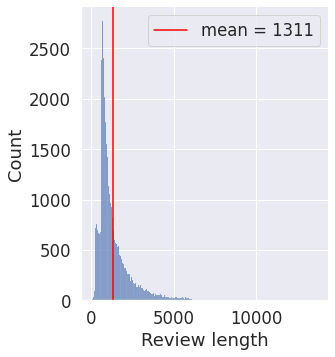

In [6]:
# Checking the distribution of the review lengths
# This will be used to inform the decision about the embeddings size
lengths = []
for sample in train['text']:
  lengths.append(len(sample))
sns.displot(lengths)
plt.xlabel('Review length')
plt.axvline(np.mean(lengths), color='red', label="mean = "+str(int(np.mean(lengths))))
plt.legend(loc='upper right')
plt.show()

The BERT tokenizer handles messy text data quite remarkably. Anyways, some data preparation might lead to a better performance. This was shown in this great series of articles produced by a fellow Minervan and a great friend of mine, Alexander ([article 1](https://towardsdatascience.com/part-1-data-cleaning-does-bert-need-clean-data-6a50c9c6e9fd) and [article 2](https://towardsdatascience.com/does-bert-need-clean-data-part-2-classification-d29adf9f745a)). Given his findings from those experiments, I will only perform a light preprocessing of the text used to fine-tune BERT.

In [7]:
# Creating a preprocessing function
def preprocess(txt):
    # Removing any URLs
    txt = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", ' ', txt)
    # Removing any non-letter symbols (e.g. '!', '?', ':)')
    txt = re.sub(r'[^a-zA-Z]+', ' ', txt)
    # Removing the line breaks
    txt = re.sub('<br />', '', txt)
    txt = re.sub('\n', '', txt)
    # Removing punctuation
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)
    return txt
    

train['text'] = train['text'].apply(preprocess)
val['text'] = val['text'].apply(preprocess)
test['text'] = test['text'].apply(preprocess)

train.head(5)

,text,label
0,I grew up b watching and loving the Thunderbir...,0
1,When I put this movie in my DVD player and sat...,0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [8]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [9]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [10]:
# setting the seed value for reproducibility
seed_val = 22

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [11]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

# Prepaing for training (utils functions)

The tokenization and the training loop used in this assignment is based on the notebook used for the study guide in the session I was leading on Transformers. This notebook can be accessed [here](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX?usp=sharing#scrollTo=oCYZa1lQ8Jn8&line=9&uniqifier=2).

In [12]:
# As we saw earlier, some reviews are quite long and the mean of their
# length is over 1000 words. The maximum input length that BERT allows for
# is 512. I will thus use this number 
max_len = 256

# creating a function to take care of tokenizing the input and converting
# it into a format required by BERT
def tokenize(df, max_len):
  reviews = df.text.values
  labels = df.label.values
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for rev in reviews:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          rev,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_len,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          truncation=True,
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  # Combining the inputs into a TensorDataset
  dataset = TensorDataset(input_ids, attention_masks, labels)

  return dataset

# applying the function to all the datasets (train, val, test)
trainSet = tokenize(train, max_len)
valSet = tokenize(val, max_len)
testSet = tokenize(test, max_len)



In [13]:
# We need to create a DataLoader object for training with BERT
# Batch size has to be specified for the DL
batch_size = 32

def generate_Data_Loader(df, b_size, randomize):
  if randomize:
    return DataLoader(
            df,  # The training samples.
            sampler = RandomSampler(df), # Select batches randomly
            batch_size = b_size # Trains with this batch size.
            )
  else:
    return DataLoader(
            df,  # The training samples.
            sampler = SequentialSampler(df), # Select batches randomly
            batch_size = b_size # Trains with this batch size.
            )

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
# For validation and test, the order doesn't matter, so we load them sequentially.
train_dataloader = generate_Data_Loader(trainSet, batch_size, True)
validation_dataloader = generate_Data_Loader(valSet, batch_size, False)
test_dataloader = generate_Data_Loader(testSet, batch_size, False)


In [14]:
# Function to calculate the accuracy, precision, and F1 score of our predictions
def calc_metrics(preds, labels, all_batches):
    # when we're taking all the batches for the calculation, 
    # we need to concatenate the predictions from all the batches
    if all_batches:
      preds = np.concatenate(preds, axis=0)
      labels = np.concatenate(labels, axis=0)
    pred_flat = np.argmax(preds, axis=1).flatten()
    accuracy = metrics.accuracy_score(labels, pred_flat)
    precision = metrics.precision_score(labels, pred_flat)
    recall = metrics.recall_score(labels, pred_flat)
    f1 = metrics.f1_score(labels, pred_flat) 
    return accuracy, precision, recall, f1


In [15]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
# If you run out of memory on the cell below, run this:
# torch.cuda.empty_cache()

In [16]:
# creating a function to train a model
def model_training(
    model, 
    train_set, 
    val_set, 
    n_epochs, 
    optimizer, 
    warmup_steps, 
    learning_rate, 
    scale_parameter=False, 
    relative_step=False, 
    warmup_init=False
    ):
  # Total number of training steps is [number of batches] x [number of epochs]. 
  total_steps = len(train_set) * n_epochs
  
  # Instantiating the optimizer based on the input to the training function
  if optimizer == 'AdamW':
    optimizer = AdamW(model.parameters(),
                      lr = learning_rate, 
                      eps = 1e-8 
                    )
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)
  elif optimizer == 'Adafactor':
    optimizer = Adafactor(model.parameters(), 
                          scale_parameter=scale_parameter, 
                          relative_step=relative_step, 
                          warmup_init=warmup_init, 
                          lr=learning_rate
                          )
    scheduler = AdafactorSchedule(optimizer)
  
  # Instantiate a list to hold the training results
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, n_epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode
      model.train()

      # Run training over each batch in the training data
      for step, batch in enumerate(train_set):

          # Progress update every 100 batches.
          if step % 100 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_set), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # clearing the previous gradients for the backward pass
          # this has to be done because PyTorch automatically accumulates the 
          # gradients, which is useful for RNN models
          model.zero_grad()        

          # Perform a forward pass on the given training batch and store the results
          result = model(b_input_ids, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)

          loss = result.loss
          logits = result.logits

          # add the loss of the current batch to the global loss variable
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # normalize the gradients to prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # update the parameters using the results of the backward pass
          optimizer.step()

          # update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_set)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_precision = 0
      total_eval_recall = 0
      total_eval_f1 = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in val_set:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              result = model(b_input_ids, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          # Get the loss and "logits" output by the model. The "logits" are the 
          # output values prior to applying an activation function like the 
          # softmax.
          loss = result.loss
          logits = result.logits
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          tmp_accuracy, tmp_precision, tmp_recall, tmp_f1 = calc_metrics(logits, label_ids, False)
          total_eval_accuracy += tmp_accuracy
          total_eval_precision += tmp_precision
          total_eval_recall += tmp_recall
          total_eval_f1 += tmp_f1
          

      # Report the final metrics for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(val_set)
      avg_val_precision = total_eval_precision / len(val_set)
      avg_val_recall = total_eval_recall / len(val_set)
      avg_val_f1 = total_eval_f1 / len(val_set)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
      print("  Precision: {0:.2f}".format(avg_val_precision))
      print("  Recall: {0:.2f}".format(avg_val_recall))
      print("  F1: {0:.2f}".format(avg_val_f1))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(val_set)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Valid. Prec.': avg_val_precision,
              'Valid. Recall': avg_val_recall,
              'Valid. F1': avg_val_f1,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return training_stats



In [17]:
# Display floats with two decimal places.
pd.set_option('precision', 2)
def generate_results_table(results):

  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(data=results)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')

  return df_stats

In [18]:
# creating a function to generate the plot with training and validation losses
def generate_loss_curve(stats):
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(stats['Training Loss'], 'b-o', label="Training")
  plt.plot(stats['Valid. Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4])

  plt.show()

In [19]:
# Prediction on test set

def predict(model, test_set):
  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in test_set:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                      attention_mask=b_input_mask,
                      return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  return predictions , true_labels


# Training and evaluation

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

Training  DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=Fals

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  Batch   100  of  1,242.    Elapsed: 0:02:19.
  Batch   200  of  1,242.    Elapsed: 0:04:37.
  Batch   300  of  1,242.    Elapsed: 0:06:55.
  Batch   400  of  1,242.    Elapsed: 0:09:13.
  Batch   500  of  1,242.    Elapsed: 0:11:30.
  Batch   600  of  1,242.    Elapsed: 0:13:48.
  Batch   700  of  1,242.    Elapsed: 0:16:06.
  Batch   800  of  1,242.    Elapsed: 0:18:24.
  Batch   900  of  1,242.    Elapsed: 0:20:42.
  Batch 1,000  of  1,242.    Elapsed: 0:23:00.
  Batch 1,100  of  1,242.    Elapsed: 0:25:18.
  Batch 1,200  of  1,242.    Elapsed: 0:27:36.

  Average training loss: 0.47
  Training epoch took: 0:28:33

Running Validation...
  Accuracy: 0.82
  Precision: 0.80
  Recall: 0.86
  F1: 0.82
  Validation Loss: 0.45
  Validation took: 0:01:21

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,242.    Elapsed: 0:02:18.
  Batch   200  of  1,242.    Elapsed: 0:04:36.
  Batch   300  of  1,242.    Elapsed: 0:06:54.
  Batch   400  of  1,242.    Elapsed: 0:09:11.
  Batch 

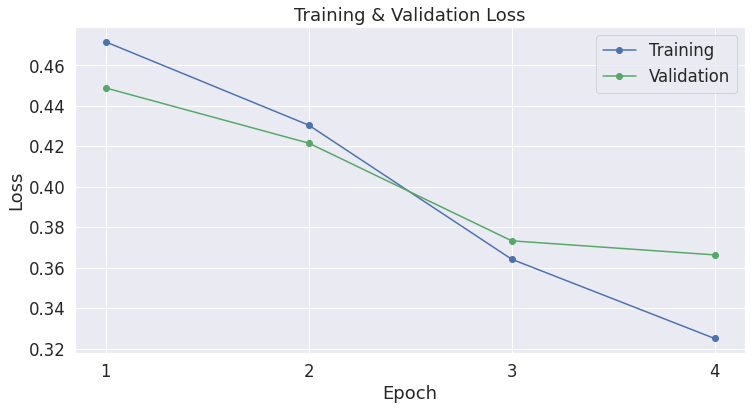

F1 Score = 0.8618015510041758
Precision = 0.8575385833003561
Recall = 0.8661071143085531
Accuracy = 0.8608608608608609
------------------------------------------------------------------------


Training  DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  Batch   100  of  1,242.    Elapsed: 0:02:16.
  Batch   200  of  1,242.    Elapsed: 0:04:32.
  Batch   300  of  1,242.    Elapsed: 0:06:49.
  Batch   400  of  1,242.    Elapsed: 0:09:05.
  Batch   500  of  1,242.    Elapsed: 0:11:21.
  Batch   600  of  1,242.    Elapsed: 0:13:37.
  Batch   700  of  1,242.    Elapsed: 0:15:53.
  Batch   800  of  1,242.    Elapsed: 0:18:09.
  Batch   900  of  1,242.    Elapsed: 0:20:26.
  Batch 1,000  of  1,242.    Elapsed: 0:22:42.
  Batch 1,100  of  1,242.    Elapsed: 0:24:58.
  Batch 1,200  of  1,242.    Elapsed: 0:27:15.

  Average training loss: 0.38
  Training epoch took: 0:28:11

Running Validation...
  Accuracy: 0.89
  Precision: 0.87
  Recall: 0.91
  F1: 0.89
  Validation Loss: 0.27
  Validation took: 0:01:20

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,242.    Elapsed: 0:02:16.
  Batch   200  of  1,242.    Elapsed: 0:04:32.
  Batch   300  of  1,242.    Elapsed: 0:06:48.
  Batch   400  of  1,242.    Elapsed: 0:09:05.
  Batch 

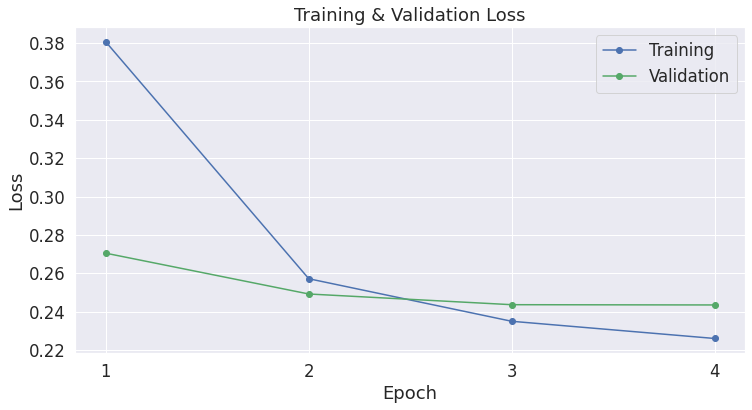

F1 Score = 0.8979348689436061
Precision = 0.8922651933701657
Recall = 0.9036770583533174
Accuracy = 0.8970970970970971
------------------------------------------------------------------------


Training  DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, 

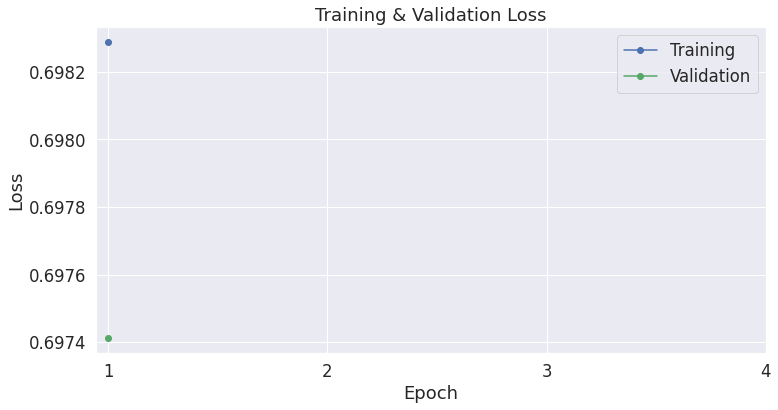

F1 Score = 0.6674669867947178
Precision = 0.5009009009009009
Recall = 1.0
Accuracy = 0.5009009009009009
------------------------------------------------------------------------


Training  DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=76

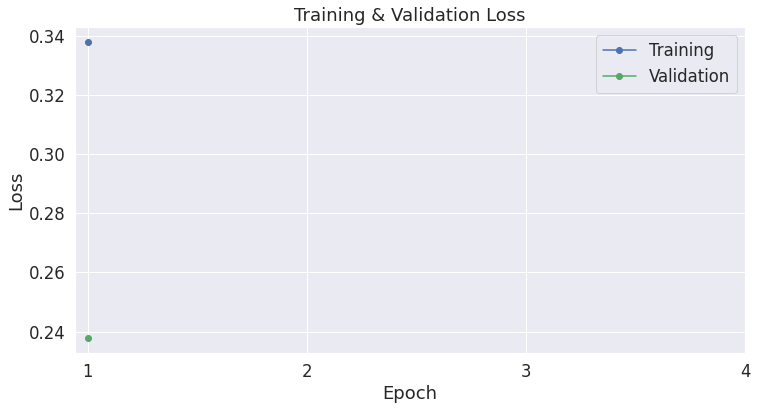

F1 Score = 0.9028688524590163
Precision = 0.9264087468460892
Recall = 0.8804956035171863
Accuracy = 0.9051051051051051
------------------------------------------------------------------------




In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
all_models = []
all_models_params = []

bert1 = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
bert2 = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
bert3 = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
bert4 = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
bert1.cuda()
bert2.cuda()
bert3.cuda()
bert4.cuda()

all_models.append(bert1)
all_models.append(bert2)
all_models.append(bert3)
all_models.append(bert4)


model1_params = {
    'n_epochs' : 4,
    'optimizer' : 'AdamW',
    'warmup_steps' : 0,
    'learning_rate' : 2e-4,
    'scale_parameter' : False,
    'relative_step' : False,
    'warmup_init' : False
}
model2_params = {
    'n_epochs' : 4,
    'optimizer' : 'AdamW',
    'warmup_steps' : 100,
    'learning_rate' : 2e-6,
    'scale_parameter' : False,
    'relative_step' : False,
    'warmup_init' : False
}
model3_params = {
    'n_epochs' : 4,
    'optimizer' : 'Adafactor',
    'warmup_steps' : 100,
    'learning_rate' : 2e-5,
    'scale_parameter' : False,
    'relative_step' : False,
    'warmup_init' : False
}
model4_params = {
    'n_epochs' : 4,
    'optimizer' : 'Adafactor',
    'warmup_steps' : 0,
    'learning_rate' : None,
    'scale_parameter' : True,
    'relative_step' : True,
    'warmup_init' : True
}


all_models_params.append(model1_params)
all_models_params.append(model2_params)
all_models_params.append(model3_params)
all_models_params.append(model4_params)

  
for model, params in zip(all_models, all_models_params):
  print("Training ", model)
  model_stats = model_training(
      model, 
      train_dataloader,
      validation_dataloader,
      params['n_epochs'], 
      params['optimizer'],
      params['warmup_steps'],
      params['learning_rate'],
      params['scale_parameter'],
      params['relative_step'],
      params['warmup_init'],
  )
  stats_table = generate_results_table(model_stats)
  stats_table.head(10)
  generate_loss_curve(stats_table)
  preds, labels = predict(model, test_dataloader)
  accuracy, precision, recall, f1 = calc_metrics(preds, labels, True)
  print("F1 Score =", f1)
  print("Precision =", precision)
  print("Recall =", recall)
  print("Accuracy =", accuracy)
  print("------------------------------------------------------------------------")
  print("")
  print("")


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training  DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=Fals

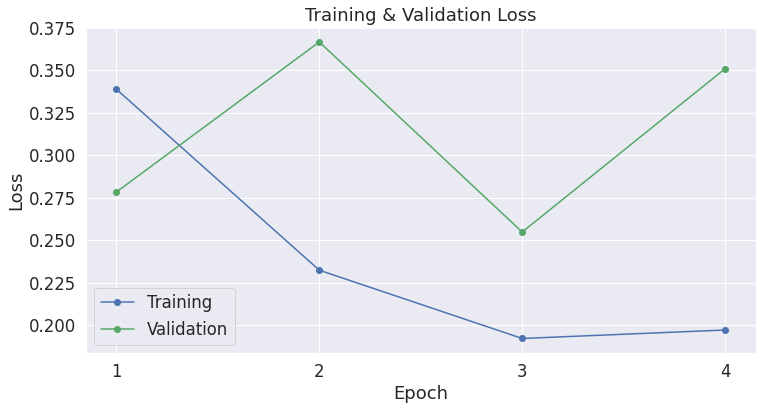

F1 Score = 0.878302642113691
Precision = 0.8797113071371291
Recall = 0.876898481215028
Accuracy = 0.8782782782782783
------------------------------------------------------------------------




In [ ]:
# I ran the last two models for 1 epoch only. 
# The hyperparameters used in the first one were not leading to good performance
# So I will ignore this model
# I will retrain the last model in this cell

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
all_models = []
all_models_params = []

bert4 = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
bert4.cuda()

all_models.append(bert4)


model4_params = {
    'n_epochs' : 4,
    'optimizer' : 'Adafactor',
    'warmup_steps' : 0,
    'learning_rate' : None,
    'scale_parameter' : True,
    'relative_step' : True,
    'warmup_init' : True
}


all_models_params.append(model4_params)

  
for model, params in zip(all_models, all_models_params):
  print("Training ", model)
  model_stats = model_training(
      model, 
      train_dataloader,
      validation_dataloader,
      params['n_epochs'], 
      params['optimizer'],
      params['warmup_steps'],
      params['learning_rate'],
      params['scale_parameter'],
      params['relative_step'],
      params['warmup_init'],
  )
  stats_table = generate_results_table(model_stats)
  stats_table.head(10)
  generate_loss_curve(stats_table)
  preds, labels = predict(model, test_dataloader)
  accuracy, precision, recall, f1 = calc_metrics(preds, labels, True)
  print("F1 Score =", f1)
  print("Precision =", precision)
  print("Recall =", recall)
  print("Accuracy =", accuracy)
  print("------------------------------------------------------------------------")
  print("")
  print("")


From the results obtained above, it looks like the second model is the best performing. One way in which its performance can be improved even more is by increasing the size of embeddings fed into BERT. For all of the initial experiments, the embedding size of 256 was used. BERT allows for the maximum of 512 tokens to be fed into it and as we saw at the beginning of this notebook, most of the reviews contain more words than that number. It is thus worth to increase the size of the embeddings to the maximum allowed and re-train the model again with the best hyperparameters. This is done in the cell below.

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  2,483.    Elapsed: 0:01:16.
  Batch   200  of  2,483.    Elapsed: 0:02:32.
  Batch   300  of  2,483.    Elapsed: 0:03:48.
  Batch   400  of  2,483.    Elapsed: 0:05:04.
  Batch   500  of  2,483.    Elapsed: 0:06:20.
  Batch   600  of  2,483.    Elapsed: 0:07:36.
  Batch   700  of  2,483.    Elapsed: 0:08:52.
  Batch   800  of  2,483.    Elapsed: 0:10:08.
  Batch   900  of  2,483.    Elapsed: 0:11:25.
  Batch 1,000  of  2,483.    Elapsed: 0:12:41.
  Batch 1,100  of  2,483.    Elapsed: 0:13:57.
  Batch 1,200  of  2,483.    Elapsed: 0:15:13.
  Batch 1,300  of  2,483.    Elapsed: 0:16:29.
  Batch 1,400  of  2,483.    Elapsed: 0:17:45.
  Batch 1,500  of  2,483.    Elapsed: 0:19:02.
  Batch 1,600  of  2,483.    Elapsed: 0:20:18.
  Batch 1,700  of  2,483.    Elapsed: 0:21:34.
  Batch 1,800  of  2,483.    Elapsed: 0:22:50.
  Batch 1,900  of  2,483.    Elapsed: 0:24:06.
  Batch 2,000  of  2,483.    Elapsed: 0:25:22.
  Batch 2,100  of

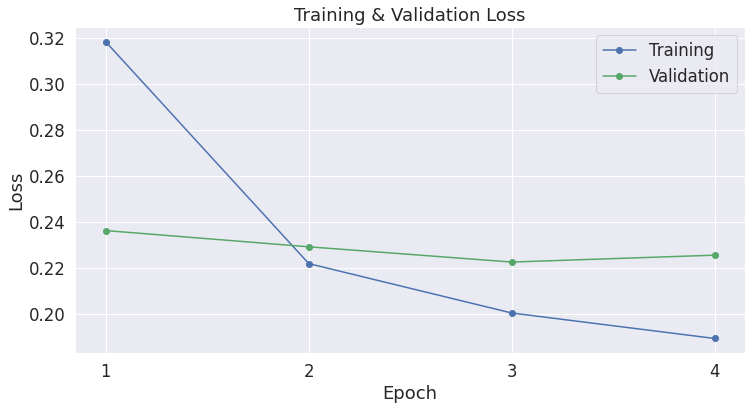

F1 Score = 0.9162345432788194
Precision = 0.9144108280254777
Recall = 0.9180655475619505
Accuracy = 0.9159159159159159


In [20]:
max_len = 512
# made the batch size smaller for this experiment to fit the data on the GPU
batch_size = 16 

# applying the function to all the datasets (train, val, test)
trainSet = tokenize(train, max_len)
valSet = tokenize(val, max_len)
testSet = tokenize(test, max_len)

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
# For validation and test, the order doesn't matter, so we load them sequentially.
train_dataloader = generate_Data_Loader(trainSet, batch_size, True)
validation_dataloader = generate_Data_Loader(valSet, batch_size, False)
test_dataloader = generate_Data_Loader(testSet, batch_size, False)

final_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
final_model.cuda()

final_model_params = {
    'n_epochs' : 4,
    'optimizer' : 'AdamW',
    'warmup_steps' : 100,
    'learning_rate' : 2e-6,
    'scale_parameter' : False,
    'relative_step' : False,
    'warmup_init' : False
}


model_stats = model_training(
    final_model, 
    train_dataloader,
    validation_dataloader,
    final_model_params['n_epochs'], 
    final_model_params['optimizer'],
    final_model_params['warmup_steps'],
    final_model_params['learning_rate'],
    final_model_params['scale_parameter'],
    final_model_params['relative_step'],
    final_model_params['warmup_init'],
)
stats_table = generate_results_table(model_stats)
stats_table.head(10)
generate_loss_curve(stats_table)
preds, labels = predict(final_model, test_dataloader)
accuracy, precision, recall, f1 = calc_metrics(preds, labels, True)
print("F1 Score =", f1)
print("Precision =", precision)
print("Recall =", recall)
print("Accuracy =", accuracy)


# Discussion

For this assignment, I have decided to use the pre-trained Bidirectional Encoder Representations from Transformers (BERT) model develop be Google. The main reason behind this decision was that BERT is a state-of-art model for NLP tasks and it is well-suited for the sentiment classification tasks, which is the objective in this notebook. I decided to fine-tune the entire model because I had access to a free cloud GPU provided in Google Colab notebooks. With this approach, it was the most likely to obtain the best performance. An alternative to my approach could be to use the weights of the pre-trained model, unfreeze only the last layer(s) and train those. Additionally, I could leave the entire model frozen, add (a) layer(s) on top of it and only train those. Given the computational resources I had and the time (I started the assignment early), I decided to proceed with the first approach described. 

In terms of other design choices, I have splitted the data into 3 sets: training, validation, and testing. The first one was used to train the model and the second one was used to monitor the performance of the model after each training batch. After the entire training loop was finished, I was testing the performance of all the models on the test dataset, which was unseen before by all the models. The performance on this dataset should serve as the most representative of the models' generalizability. 

All of the models were trained for 4 epochs. Each model has different hyperparameters. For the first 2, the weighted Adam is used as the optimizer and for the latter 2, the Adafator is utilized. I think that a deep discussion of those is beyond the scope of this assignment, but there are certain differences between them which might lead to different results. Learning rate and the number of steps used for warmup were variable across the models as well. It's worth noting, however, that the hyperparameter tuning in this project is by no means exhaustive and, time permitting, the extension to this work could include testing different learning parameters. 

As we can see from the performances of the model tested, it is possible to use a pre-trained model such as BERT on a new dataset and achieve state-of-art results without a significant effort. Such models can be used for multiple tasks from other domains of NLP, e.g. Named Entity Recognition. 

The best model used DistilBERT which is a smaller verion of the BERT model which preserves around 95% of its larger counterpart's performance. The best model has used the weighted Adam optimizer with 100 warmup steps and a learning rate of 2e-6. Its performance on the test set was:
- F1 Score = 0.916
- Precision = 0.914
- Recall = 0.918
- Accuracy = 0.916.

These results are very close to the state of the art found in the literature on the similar tasks.